# Notebook to qc the given demographic file and summarise info 
### This notebook has been adapted for H10 demographic file

In [42]:
import os
import glob
import pandas as pd
import numpy as np
import json
import shutil
import matplotlib.pyplot as plt

In [43]:
# initialise 

site_code = 'H10'
site_folder = f'/home/mathilde/Documents/RDS/MELD_FE/DATA/MELD_{site_code}'

csv_file = os.path.join(site_folder,f'MELD_participants_infos_{site_code}.csv')
df_raw=pd.read_csv(csv_file)
df_raw.head()

df = df_raw.copy()

## 1. Check data 

In [44]:
columns = ['id', 'redcap_data_access_group', 'site', 'patient_control', 'sex',
       'radiology', 'radiology_report', 'field_strengths___1',
       'field_strengths___2', 'field_strengths___3', 'age_at_preop_t1_15t',
       'age_at_preop_t1_3t', 'age_at_preop_t1_7t', 'preop_t1_yr_15t',
       'preop_t1_yr_3t', 'preop_t1_yr_7t', 'postop_t1_yr',
       'postop_t1_yr_2___1', 'postop_t1_yr_2___2', 'postop_t1_yr_2___3',
       'control_headache', 'preop_t1', 'preop_t2', 'preop_flair', 'preop_dwi',
       'postop_t1', 'fields', 'lesion_mask', 'age_at_onset', 'gtcs',
       'drug_resistant', 'aeds', 'mri_negative', 'seeg', 'operated',
       'surgery_year', 'age_at_surgery', 'mri_negative_surgery', 'procedure',
       'procedure_other', 'histology', 'histology_other', 'seizure_free',
       'seizure_free_aura', 'engel_1yr', 'ilae_1yr', 'engel', 'ilae',
       'follow_up', 'aeds_post_op', 'participant_information_complete']

In [45]:
data_type_constraints = {
    'id': str, 
    'site':str,
    'patient_control':[1,2], 
    'sex':[0,1],
    'radiology':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23],
    'control_headache':[1,2,555],
    'lesion_mask':[0,1,555],
    'age_at_onset': float,
    'gtcs':[0,1,3],
    'drug_resistant':[0,1,3],
    'aeds': str,
    'mri_negative': [0,1,3],
    'seeg':[0,1,3],
    'operated':[0,1,3],
    'age_at_surgery': float,
    'mri_negative_surgery':[0,1,555],
    'procedure': [1,2,3,4,555],
    'histology': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23],
    'seizure_free':[1,2,555],
    'seizure_free_aura':[1,2,555],
    'engel_1yr':[1,2,3,4,555],
    'ilae_1yr':[1,2,3,4,5,6,555],
    'engel':[1,2,3,4,5,6,555],
    'ilae' :[1,2,3,4,5,6,555],
    'aeds_post_op':[1,2,3,555],
}

In [46]:
df_qc=pd.DataFrame()

values={}
for column in columns:
    values['column']=column

    #check number of values that have been filled
    non_nan_values = df[column].dropna()
    non_nan_count = non_nan_values.count()
    values['Non-NaN Count'] = non_nan_count
    
    #check the type of the data
    data_type = df[column].values.dtype
    values['Data Type']= data_type
    
    #check that type and values are in given constraints
    if non_nan_count>0:
        if column in data_type_constraints:
            constraint = data_type_constraints[column]
            
            # Check if values in constraints or dtype
            if isinstance(constraint, list):
                valid_values = set(constraint)
                valid_values.add(np.NAN)  # Allow 'NaN' values in the constraint
                is_valid = non_nan_values.map(lambda x: x in valid_values).all()
            else:
                is_valid = non_nan_values.astype(constraint).equals(non_nan_values)
        else:
            # If no constraint is specified, assume it's valid
            is_valid = np.nan
    else:
       is_valid = np.nan
    values['Is Valid']= is_valid 
    
    df_qc = pd.concat([df_qc,pd.DataFrame([values])])


In [47]:
df_qc

,column,Non-NaN Count,Data Type,Is Valid
0,id,333,object,1.0
0,redcap_data_access_group,0,float64,NaN
0,site,333,object,1.0
0,patient_control,333,int64,1.0
0,sex,333,int64,1.0
0,radiology,59,float64,1.0
0,radiology_report,59,object,NaN
0,field_strengths___1,0,float64,NaN
0,field_strengths___2,333,int64,NaN
0,field_strengths___3,0,float64,NaN


In [48]:
#check the column that does not have information
df_qc[df_qc['Non-NaN Count']<1]

,column,Non-NaN Count,Data Type,Is Valid
0,redcap_data_access_group,0,float64,NaN
0,field_strengths___1,0,float64,NaN
0,field_strengths___3,0,float64,NaN
0,age_at_preop_t1_15t,0,float64,NaN
0,age_at_preop_t1_7t,0,float64,NaN
0,preop_t1_yr_15t,0,float64,NaN
0,preop_t1_yr_7t,0,float64,NaN
0,postop_t1_yr_2___1,0,float64,NaN
0,postop_t1_yr_2___3,0,float64,NaN
0,histology_other,0,float64,NaN


In [49]:
# check column not valid
df_qc[df_qc['Is Valid']==0]

,column,Non-NaN Count,Data Type,Is Valid
0,histology,59,float64,0.0


## 2. Quick summary of the data

In [50]:
# only look at the one included
subdf = df[df['included']==1]

In [53]:
#Total subjects

num_subjects = len(subdf)

print('Number of subjects: {} subjects'.format(num_subjects))

Number of subjects: 333 subjects


In [54]:
# patients or controls

key='patient_control'
num_patients = len(subdf[subdf[key]==1])
num_controls = len(subdf[subdf[key]==2])

print('Group: {} patients - {} controls'.format(int(num_patients), int(num_controls)))

Group: 59 patients - 274 controls


In [55]:
# check how many had surgery and check with MRI negative
key1='operated'
key2='mri_negative'
key3='histology'
subdf.groupby([key1,key2,key3])[key3].count()

operated  mri_negative  histology
1.0       0.0           1.0           1
                        3.0           1
                        10.0         53
                        11.0          1
                        555.0         1
          1.0           2.0           1
                        12.0          1
Name: histology, dtype: int64

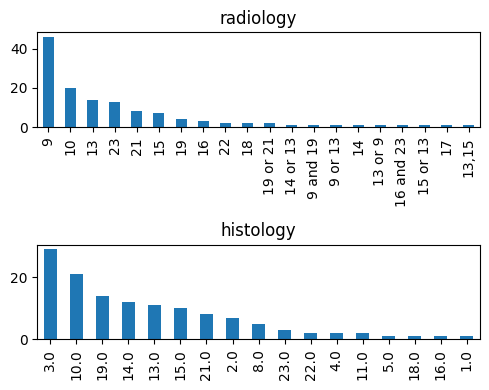

In [39]:
# list the radiological and histopathological diagnosis

keys = ['radiology','histology']
fig, axs = plt.subplots(len(keys), 1, figsize=(5,2*len(keys)))
for i,key in enumerate(keys):
    subdf[key].value_counts().plot(kind='bar',title=key, ax=axs[i]) 
plt.tight_layout()

In [40]:
# check lesion mask available for non-HS

key2 = 'lesion_mask',
key1 = 'histology'
subdf.groupby([key1])[key2].sum()    

,lesion_mask
histology,
1.0,0.0
2.0,0.0
3.0,0.0
4.0,0.0
5.0,0.0
8.0,0.0
10.0,0.0
11.0,0.0
13.0,0.0


IndexError: index 0 is out of bounds for axis 0 with size 0

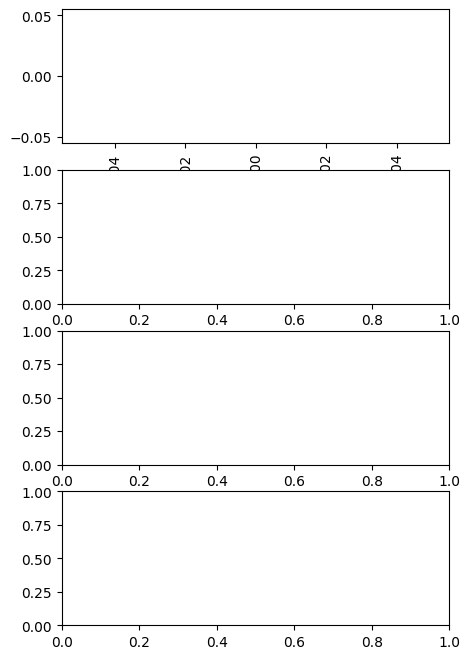

In [41]:
# check the outcomes

keys=[ 'engel_1yr',
       'ilae_1yr',
       'engel',
       'ilae',
       ]
fig, axs = plt.subplots(len(keys), 1, figsize=(5,2*len(keys)))
for i,key in enumerate(keys):
    subdf[key].value_counts().plot(kind='bar',title=key[32:80], ax=axs[i]) 
plt.tight_layout()

<AxesSubplot:ylabel='What was the radiological diagnosis?'>

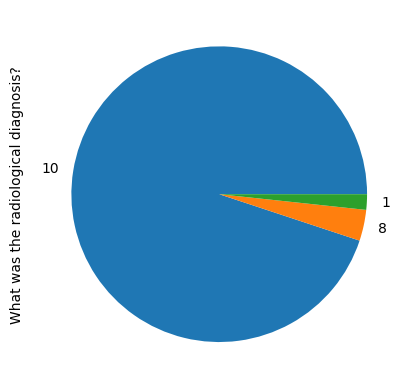

In [107]:
# kwargs = dict(
#     startangle = 90,
#     colormap   = 'Pastel2',
#     fontsize   = 13,
#     explode    = (0.1,0.1),
#     figsize    = (60,5),
#     autopct    = '%1.1f%%',
#     title      = 'group'
# )

# df[key].value_counts().plot.pie()